In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator


# Suprimir advertencias futuras sobre opciones descontinuadas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Actividad 1: Análisis exploratorio de los datos

In [167]:
# Loading the dataset
df = pd.read_csv('data/data_reto4_24.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,55,12/01/2009 07:45,72.79,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,53,12/01/2009 07:45,88.87,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,95,12/01/2009 07:45,7.78,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",64,12/01/2009 07:45,26.02,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,28,12/01/2009 07:45,39.13,13085.0,United Kingdom


### a. Preprocesamiento

¿Cuántas observaciones y variables tiene el dataset? ¿Qué tipo de variables son? ¿Qué variables contienen valores nulos? Elimina los registros con descripción del producto nula y cuando no haya registro de cliente.

In [168]:
print("Dimension of data", df.shape)
print("Number of samples:",len(df))
print("Number of variables:", len(df.dtypes), "\n")
df.info()

Dimension of data (1044847, 8)
Number of samples: 1044847
Number of variables: 8 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044847 entries, 0 to 1044846
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1044847 non-null  object 
 1   StockCode    1044847 non-null  object 
 2   Description  1040572 non-null  object 
 3   Quantity     1044847 non-null  int64  
 4   InvoiceDate  1044847 non-null  object 
 5   Price        1044847 non-null  float64
 6   Customer ID  809560 non-null   float64
 7   Country      1044847 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 63.8+ MB


In [169]:
# registros con valores nulos
df.isna().sum()

Invoice             0
StockCode           0
Description      4275
Quantity            0
InvoiceDate         0
Price               0
Customer ID    235287
Country             0
dtype: int64

In [170]:
# Eliminar registros con valores nulos en 'Description' o 'Customer ID'
df_c = df.dropna(subset=['Description', 'Customer ID'])
df_c.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

### b. Creación variable de ganancias

Para poder analizar el valor del cliente se necesita **medir las ganancias**, para ello debéis crear la variable `Revenue`. Realiza un análisis exploratorio de las ganancias mensuales con las siguientes representaciones:

i) Mediante un gráfico de líneas se representa la distribución de las ganancias de las ventas mes a mes. 
* ¿Qué conclusión sacas a partir del gráfico? 
* ¿Se observa algún patrón en los ingresos?
* ¿Crees que alguno de los meses tiene datos incompletos? Justifica tu respuesta.

In [171]:
# Convertir "InvoiceDate" a formato de fecha
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Crear la variable "InvoiceYearMonth"
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Calcular Revenue
df['Revenue'] = df['Quantity'] * df['Price']

**Análisis exploratorio de las ganancias mensuales**

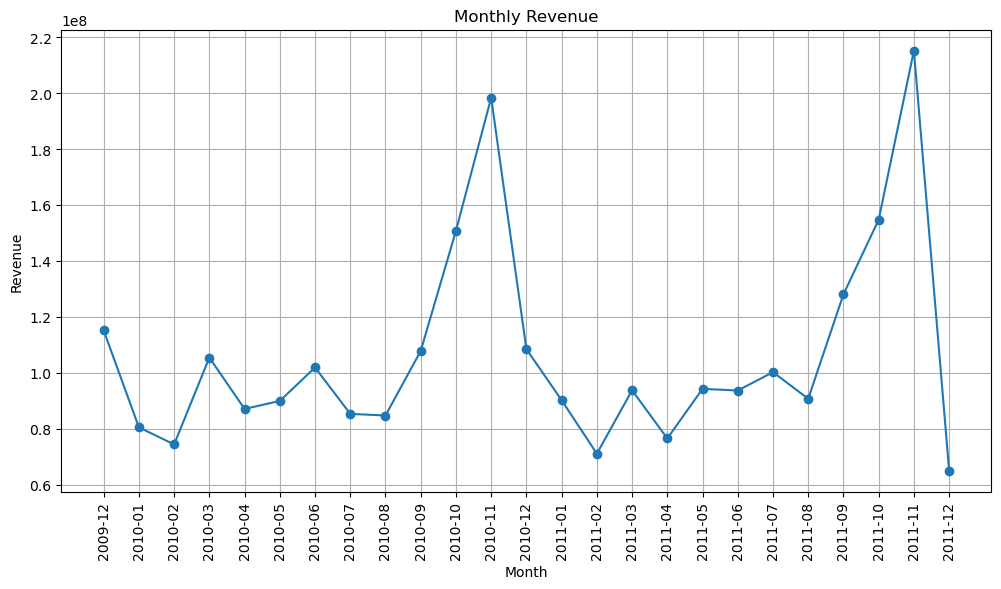

In [172]:
# Agrupar por "InvoiceYearMonth" y sumar las ganancias
monthly_revenue = df.groupby('InvoiceYearMonth')['Revenue'].sum().reset_index()

# Visualización de las ganancias mensuales

plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue['InvoiceYearMonth'].astype(str), monthly_revenue['Revenue'], marker='o')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()



<div style="background-color: AliceBlue; padding: 10px;">

Los picos en noviembre de cada año indican un patrón estacional fuerte. Este comportamiento es común en muchos negocios minoristas donde las ventas aumentan significativamente durante las temporadas de compras importantes. Esto podría estar relacionado con eventos de compras como el Black Friday o las ventas prenavideñas. Aparte de los picos en noviembre, los ingresos varían de mes a mes, con algunos meses mostrando incrementos o disminuciones notables.

**Posibles datos incompletos**: Diciembre 2011: muestra una caída abrupta en los ingresos comparados con el mes anterior (noviembre).

ii) Mediante un gráfico de líneas, debéis representar la distribución mensual de la tasa de crecimiento de ingresos mensuales. ¿Cuál es la tasa de crecimiento del último mes completo? Justifica tu respuesta.

last_complete_month_growth:  0.3906737218523597


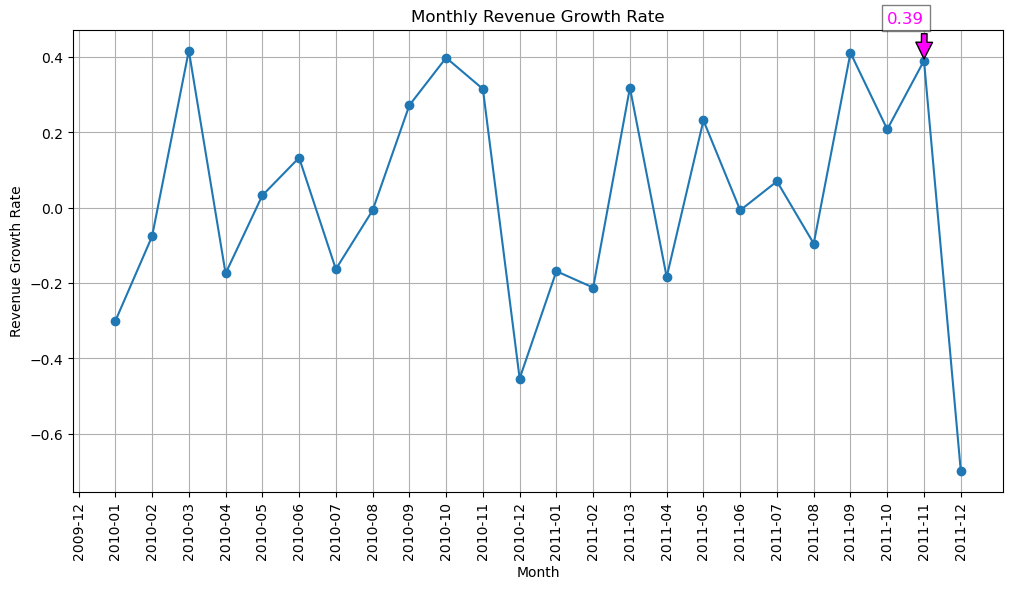

In [173]:

# Calcular la tasa de crecimiento porcentual entre meses consecutivos
monthly_revenue['RevenueGrowth'] = monthly_revenue['Revenue'].pct_change()

# Extraer el valor de la tasa de crecimiento para noviembre de 2011
last_complete_month_growth = monthly_revenue.loc[monthly_revenue['InvoiceYearMonth'] == '2011-11', 'RevenueGrowth'].values[0]

print("last_complete_month_growth: ", last_complete_month_growth)

# Graficar la tasa de crecimiento de los ingresos mensuales
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue['InvoiceYearMonth'].astype(str), monthly_revenue['RevenueGrowth'], marker='o')
plt.xlabel('Month')
plt.ylabel('Revenue Growth Rate')
plt.title('Monthly Revenue Growth Rate')
plt.xticks(rotation=90)
plt.grid(True)

# Añadir una anotación para noviembre de 2011
plt.annotate(f'{last_complete_month_growth:.2f}', 
             xy=('2011-11', last_complete_month_growth), 
             xytext=('2011-10', last_complete_month_growth + 0.1),
             arrowprops=dict(facecolor='magenta', shrink=0.05),
             fontsize=12, color='magenta', bbox=dict(facecolor='white', alpha=0.5))

plt.show()


<div style="background-color: AliceBlue; padding: 10px;">

**Último mes completo:** Dado que diciembre de 2011 tiene datos incompletos, noviembre de 2011 es considerado el último mes completo para este análisis.

* Utilizamos el método `pct_change()` para calcular la tasa de crecimiento porcentual entre meses consecutivos.
* El valor calculado `last_complete_month_growth` nos da la tasa de crecimiento de noviembre de 2011. Es decir, obtenemos la tasa de crecimiento de ingresos de noviembre de 2011 comparado con octubre de 2011 y nos proporciona información sobre la variación en los ingresos en ese período.


**Diciembre de 2010**: La disminución en la tasa de crecimiento puede deberse a una combinación de efectos estacionales, menor actividad de clientes y posibles problemas operativos.  
**Diciembre de 2011**: La tasa de crecimiento extremadamente baja se debe principalmente a datos faltantes o incompletos, ya que no hay transacciones registradas después del 9 de diciembre.

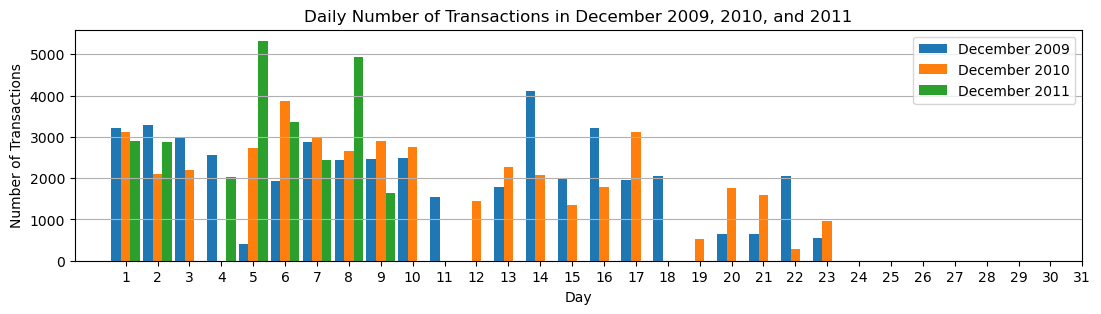

In [174]:
# Filtrar las transacciones de diciembre de 2009, 2010 y 2011
december_2009_data = df[df['InvoiceYearMonth'] == '2009-12'].copy()
december_2010_data = df[df['InvoiceYearMonth'] == '2010-12'].copy()
december_2011_data = df[df['InvoiceYearMonth'] == '2011-12'].copy()

# Contar el número de transacciones por día en diciembre de 2009, 2010 y 2011
december_2009_data['InvoiceDay'] = december_2009_data['InvoiceDate'].dt.day
december_2010_data['InvoiceDay'] = december_2010_data['InvoiceDate'].dt.day
december_2011_data['InvoiceDay'] = december_2011_data['InvoiceDate'].dt.day

daily_transactions_december_2009 = december_2009_data.groupby('InvoiceDay')['Invoice'].count().reset_index()
daily_transactions_december_2009.rename(columns={'Invoice': 'TransactionCount_2009'}, inplace=True)
daily_transactions_december_2010 = december_2010_data.groupby('InvoiceDay')['Invoice'].count().reset_index()
daily_transactions_december_2010.rename(columns={'Invoice': 'TransactionCount_2010'}, inplace=True)
daily_transactions_december_2011 = december_2011_data.groupby('InvoiceDay')['Invoice'].count().reset_index()
daily_transactions_december_2011.rename(columns={'Invoice': 'TransactionCount_2011'}, inplace=True)

# Unir los tres DataFrames por el día del mes
daily_transactions_comparison = pd.merge(daily_transactions_december_2009, daily_transactions_december_2010, on='InvoiceDay', how='outer')
daily_transactions_comparison = pd.merge(daily_transactions_comparison, daily_transactions_december_2011, on='InvoiceDay', how='outer')
daily_transactions_comparison.fillna(0, inplace=True)

plt.figure(figsize=(13, 3))
# Graficar las transacciones diarias de diciembre de 2011/2010/2009
plt.bar(daily_transactions_comparison['InvoiceDay'] - 0.3, daily_transactions_comparison['TransactionCount_2009'], width=0.3, label='December 2009', align='center')
plt.bar(daily_transactions_comparison['InvoiceDay'], daily_transactions_comparison['TransactionCount_2010'], width=0.3, label='December 2010', align='center')
plt.bar(daily_transactions_comparison['InvoiceDay'] + 0.3, daily_transactions_comparison['TransactionCount_2011'], width=0.3, label='December 2011', align='center')

plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.title('Daily Number of Transactions in December 2009, 2010, and 2011')
plt.xticks(range(1, 32))
plt.legend()
plt.grid(axis='y')
plt.show()

iii. En el gráfico del apartado ii se observan dos meses con una tasa de crecimiento muy baja. Representa gráficamente el nº de clientes activos mensuales, contando los CustomerID únicos, en un gráfico de barras y justifica que ha podido suceder en esos meses.

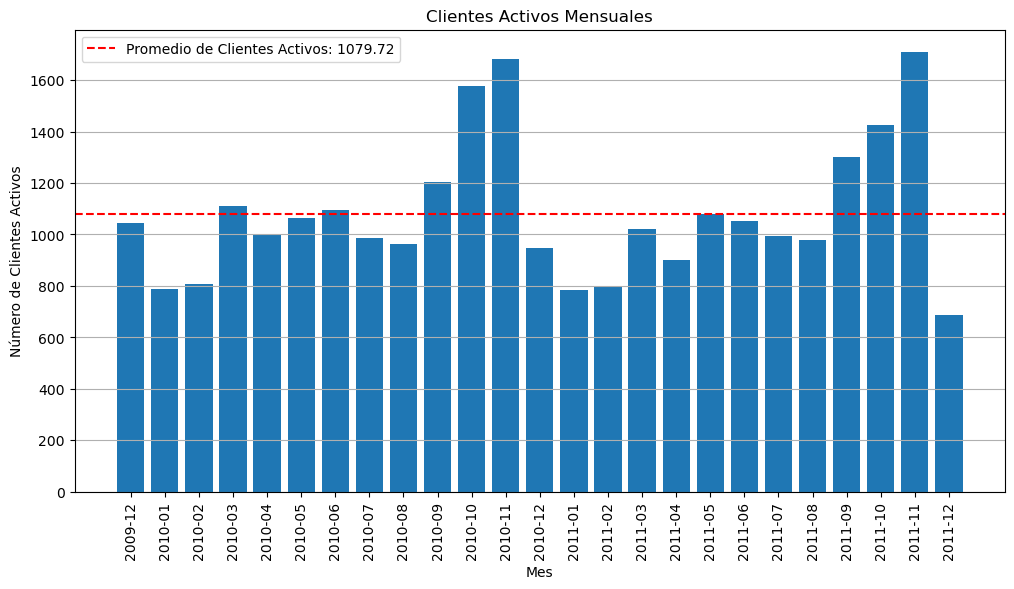

In [175]:
# Calcular el número de clientes activos mensuales
monthly_active_customers = df.groupby('InvoiceYearMonth')['Customer ID'].nunique().reset_index()
monthly_active_customers.rename(columns={'Customer ID': 'ActiveCustomers'}, inplace=True)

# Calcular el promedio del número de clientes activos
average_active_customers = monthly_active_customers['ActiveCustomers'].mean()

# Visualización del número de clientes activos mensuales
plt.figure(figsize=(12, 6))
plt.bar(monthly_active_customers['InvoiceYearMonth'].astype(str), monthly_active_customers['ActiveCustomers'])
plt.axhline(y=average_active_customers, color='r', linestyle='--', label=f'Promedio de Clientes Activos: {average_active_customers:.2f}')
plt.xlabel('Mes')
plt.ylabel('Número de Clientes Activos')
plt.title('Clientes Activos Mensuales')
plt.xticks(rotation=90)
plt.legend()
plt.grid(axis='y')
plt.show()



In [176]:
# Identificar los meses con tasas de crecimiento muy bajas
low_growth_months = monthly_revenue[monthly_revenue['RevenueGrowth'] < 0].sort_values(by='RevenueGrowth').head(2)
low_growth_months


,InvoiceYearMonth,Revenue,RevenueGrowth
24,2011-12,6.508116e+07,-0.697702
12,2010-12,1.085081e+08,-0.453199


<div style="background-color: AliceBlue; padding: 10px;">

**Diciembre de 2010**: A pesar de un número relativamente alto de clientes activos, la tasa de crecimiento de ingresos fue negativa, lo cual podría ser explicado por descuentos o promociones que redujeron el valor promedio de los pedidos.  

**Diciembre de 2011**: La caída abrupta en el número de clientes activos sugiere problemas operativos o de recopilación de datos, como interrupciones en las ventas o errores en el registro.

### c. Relación entre pedidos

Centrémonos en los pedidos que se han realizado:

i) ¿Cuáles son los productos más vendidos? ¿En qué mes, año, trimestre, semana y día se produjeron la mayoría de las transacciones?

In [177]:
df_copy = df.copy()

# añado las variables temporales
df_copy['Month'] = df_copy['InvoiceDate'].dt.month
df_copy['Time'] = df_copy['InvoiceDate'].dt.time
df_copy['Year'] = df_copy['InvoiceDate'].dt.year
df_copy['Day'] = df_copy['InvoiceDate'].dt.day
df_copy['Quarter'] = df_copy['InvoiceDate'].dt.to_period('Q')
df_copy['DayOfWeek'] = df_copy['InvoiceDate'].dt.dayofweek
df_copy['Week'] = df_copy['InvoiceDate'].dt.isocalendar().week

# Calcular los productos más vendidos
most_sold_products = df_copy.groupby(['StockCode', 'Description'])['Quantity'].sum().reset_index(
).sort_values(by='Quantity', ascending=False).head(10)

print("Most sold products:\n", most_sold_products)


Most sold products:
      StockCode                         Description  Quantity
5874    85123A  WHITE HANGING HEART T-LIGHT HOLDER    286054
2219     22423            REGENCY CAKESTAND 3 TIER    219380
5834    85099B             JUMBO BAG RED RETROSPOT    173039
5445     84879       ASSORTED COLOUR BIRD ORNAMENT    147012
4319     47566                       PARTY BUNTING    139679
826      21232      STRAWBERRY CERAMIC TRINKET BOX    131588
342      20727             LUNCH BAG  BLACK SKULL.    125093
1622     21931              JUMBO STORAGE BAG SUKI    120952
2203     22411   JUMBO SHOPPER VINTAGE RED PAISLEY    116198
5636     84991         60 TEATIME FAIRY CAKE CASES    114292


<div style="background-color: AliceBlue; padding: 10px;">

Queremos encontrar las transacciones máximas para cada periodo de tiempo (mes, año, trimestre, semana, y día del mes).

In [178]:
transactions_by_month = df_copy.groupby('Month')['Invoice'].count().reset_index(
).sort_values(by='Invoice', ascending=False).head(1)

transactions_by_year = df_copy.groupby('Year')['Invoice'].count().reset_index(
).sort_values(by='Invoice', ascending=False).head(1)

transactions_by_quarter = df_copy.groupby('Quarter')['Invoice'].count().reset_index(
).sort_values(by='Invoice', ascending=False).head(1)

transactions_by_day = df_copy.groupby('Day')['Invoice'].count().reset_index(
).sort_values(by='Invoice', ascending=False).head(1)

transactions_by_dayofweek = df_copy.groupby('DayOfWeek')['Invoice'].count().reset_index(
).sort_values(by='Invoice', ascending=False).head(1)

transactions_by_week = df_copy.groupby('Week')['Invoice'].count().reset_index(
).sort_values(by='Invoice', ascending=False).head(1)


print("\nEl año con más transacciones:\n", transactions_by_year)
print("\nEl mes específico con más transacciones:\n", transactions_by_month)
print("\nEl trimestre con más transacciones:\n", transactions_by_quarter)
print("\nLa semana con más transacciones:\n", transactions_by_week)
print("\nEl día del mes con más transacciones:\n", transactions_by_day)
print("\nEl día de la semana con más transacciones:\n", transactions_by_dayofweek)


El año con más transacciones:
    Year  Invoice
1  2010   500191

El mes específico con más transacciones:
     Month  Invoice
10     11   162726

El trimestre con más transacciones:
   Quarter  Invoice
4  2010Q4   179594

La semana con más transacciones:
     Week  Invoice
48    49    48699

El día del mes con más transacciones:
    Day  Invoice
6    7    44342

El día de la semana con más transacciones:
    DayOfWeek  Invoice
3          3   198149



ii. Representa gráficamente en un gráfico de puntos el no de transacciones por cada país y el precio medio de venta por países. ¿Qué conclusiones sacas? ¿Qué países tienen más pedidos y cuales tienen el precio de venta más alto?

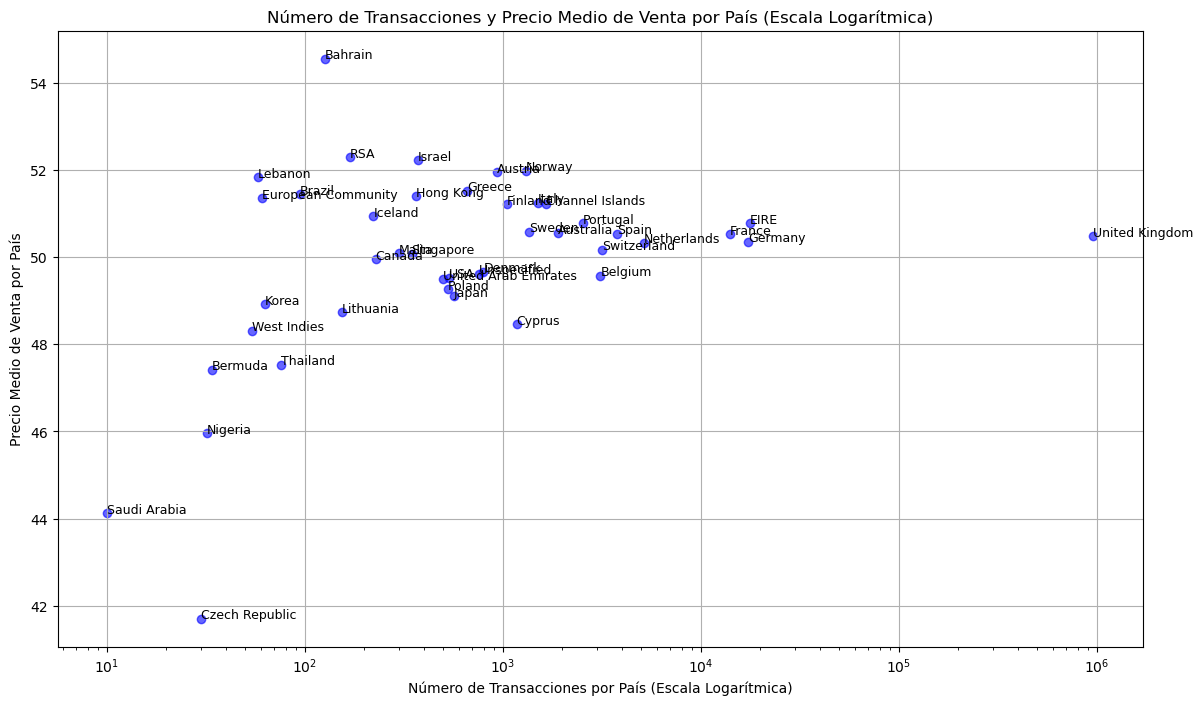

El país con más pedidos es United Kingdom con 959983 transacciones.
El país con el precio de venta más alto es Bahrain con un precio medio de 54.55.


In [179]:
# Calcular el número de transacciones por país
transacciones_por_pais = df_copy.groupby('Country')['Invoice'].count()

# Calcular el precio medio de venta por país
precio_medio_por_pais = df_copy.groupby('Country')['Price'].mean()

# Crear el gráfico de puntos
plt.figure(figsize=(14, 8))
plt.scatter(transacciones_por_pais, precio_medio_por_pais, color='b', alpha=0.6)
plt.xscale('log') # Usar escala logarítmica en el eje x
plt.xlabel('Número de Transacciones por País (Escala Logarítmica)')
plt.ylabel('Precio Medio de Venta por País')

# Añadir etiquetas de países en los puntos
for country in transacciones_por_pais.index:
    plt.text(transacciones_por_pais[country], precio_medio_por_pais[country], country, fontsize=9)


plt.title('Número de Transacciones y Precio Medio de Venta por País (Escala Logarítmica)')
plt.grid(True)
plt.show()

# Imprimir las conclusiones
max_transacciones_pais = transacciones_por_pais.idxmax()
max_transacciones = transacciones_por_pais.max()
max_precio_pais = precio_medio_por_pais.idxmax()
max_precio = precio_medio_por_pais.max()

print(f"El país con más pedidos es {max_transacciones_pais} con {max_transacciones} transacciones.")
print(f"El país con el precio de venta más alto es {max_precio_pais} con un precio medio de {max_precio:.2f}.")

<div style="background-color: AliceBlue; padding: 10px;">

La gran cantidad de transacciones en el **Reino Unido** sugiere que es el mercado más activo en términos de volumen de ventas. Esto puede deberse a una mayor base de clientes, una logística más eficiente o una mayor adopción del comercio electrónico en comparación con otros países.

El alto precio medio de venta en **Bahréin** podría indicar una preferencia por productos de mayor valor o una estructura de precios diferente. También podría reflejar un mercado con menos transacciones pero de mayor valor individual.

La mayoría de los países se agrupan en una región con un precio medio de venta entre 45 y 52, y un número de transacciones que varía entre 10 y 1000. Esto sugiere que estos mercados tienen una actividad moderada tanto en volumen como en valor de ventas.

* República Checa (Czech Republic) tiene el precio medio de venta más bajo, alrededor de 42. 
* Arabia Saudita (Saudi Arabia) también tiene un precio medio de venta relativamente bajo, alrededor de 44.
* Nigeria y Bermudas tienen un precio medio de venta ligeramente por encima del promedio, alrededor de 46 y 48 respectivamente, pero con un número de transacciones bajo.




iii. Guarda los registros generados por el país que contenga más pedidos en un dataset nuevo. Para este conjunto de datos, representa gráficamente mediante un gráfico de barras el no de pedidos mensuales. ¿Qué puedes observar para los meses atípicos del apartado b? Justifica tu respuesta.

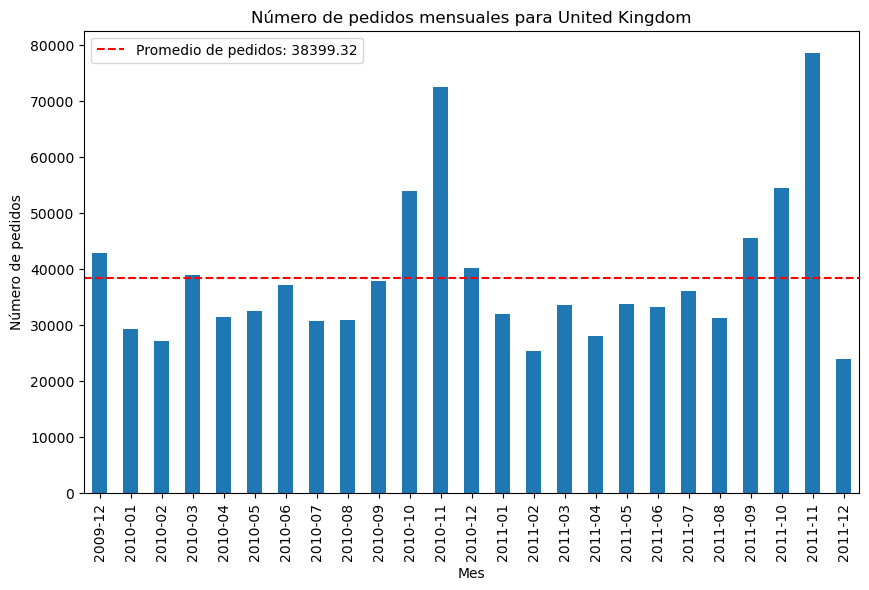

In [180]:
df_copy['InvoiceYearMonth'] = df_copy['InvoiceDate'].dt.to_period('M').astype(str)

# Encontrar el país con más pedidos
country_order_counts = df_copy['Country'].value_counts()
top_country = country_order_counts.idxmax()

# Filtrar los datos para el país con más pedidos
top_country_data = df_copy[df_copy['Country'] == top_country]

# Generar un gráfico de barras para el número de pedidos mensuales
monthly_orders = top_country_data.resample('M', on='InvoiceDate').size()

# Calcular el promedio de pedidos
average_orders = monthly_orders.mean()


# Convertir el índice a cadenas en formato 'YYYY-MM'
monthly_orders.index = monthly_orders.index.strftime('%Y-%m')

# Graficar el número de pedidos mensuales
plt.figure(figsize=(10, 6))
monthly_orders.plot(kind='bar')
plt.axhline(y=average_orders, color='r', linestyle='--', label=f'Promedio de pedidos: {average_orders:.2f}')
plt.title(f'Número de pedidos mensuales para {top_country}')
plt.xlabel('Mes')
plt.ylabel('Número de pedidos')
plt.legend()
plt.show()

<div style="background-color: AliceBlue; padding: 10px;">

**Diciembre de 2010** Número de Pedidos vs. Crecimiento de Ingresos:  
En diciembre de 2010, el número de pedidos es relativamente alto (alrededor de 40,000), pero significativamente menor que en noviembre de 2010. La tasa de crecimiento de ingresos es negativa (-0.45), indicando una disminución significativa en los ingresos. 
* Posibles Causas: Descuentos y Promociones Post-Black Friday: Después del pico de ventas en noviembre (posiblemente debido a Black Friday), diciembre pudo haber visto una continuación de promociones y descuentos, lo que resultó en ingresos promedio más bajos por pedido. Saturación del Mercado: Los clientes pudieron haber adelantado sus compras a noviembre debido a las ofertas, resultando en una menor demanda en diciembre.

**Diciembre de 2011** Número de Pedidos vs. Crecimiento de Ingresos:
En diciembre de 2011, el número de pedidos es notablemente bajo (alrededor de 20,000). La tasa de crecimiento de ingresos es extremadamente negativa (-0.70), indicando una caída drástica en los ingresos.
* Posibles Causas: Problemas Operativos o de Recopilación de Datos: La caída abrupta tanto en el número de pedidos como en los ingresos sugiere problemas operativos significativos, como interrupciones en las ventas, errores en el registro de datos, o una caída repentina en la demanda. Inexactitud en los Datos: La falta de transacciones registradas después del 9 de diciembre de 2011 apunta a problemas de datos incompletos o incorrectos.

iv. Para el mismo dataset, representa gráficamente el ingreso promedio mensual por pedido. A la vista de los gráficos desarrollados, ¿qué deduces? justifica tu respuesta.

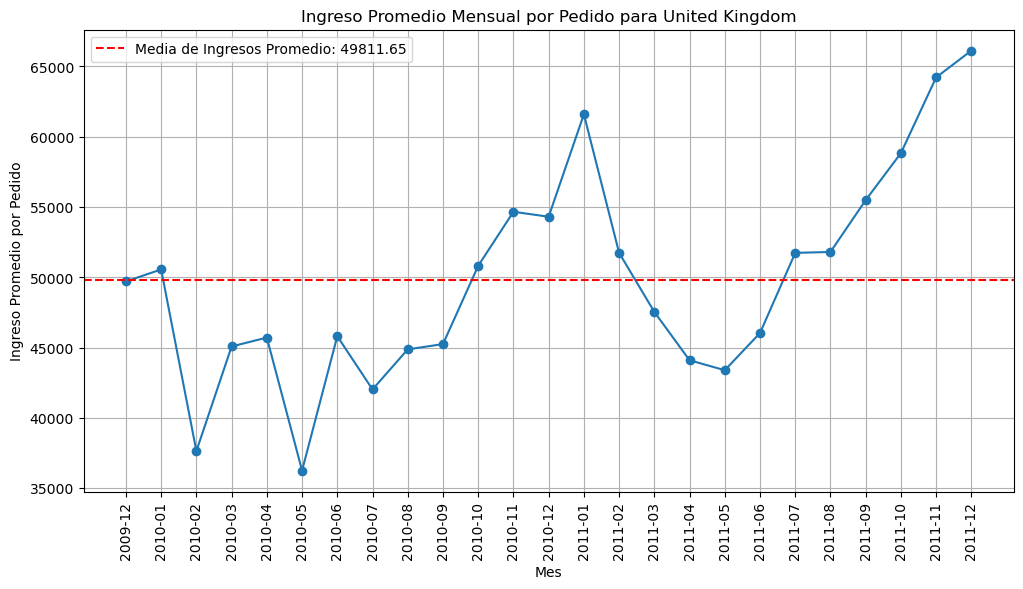

In [181]:

# Calcular el ingreso total mensual
monthly_revenue = top_country_data.groupby('InvoiceYearMonth')['Revenue'].sum().reset_index()

# Calcular el número de pedidos mensuales (número único de facturas por mes)
monthly_orders = top_country_data.groupby('InvoiceYearMonth')['Invoice'].nunique().reset_index()

# Combinar los DataFrames para calcular el ingreso promedio mensual por pedido
monthly_avg_revenue_per_order = pd.merge(monthly_revenue, monthly_orders, on='InvoiceYearMonth')
monthly_avg_revenue_per_order['AvgRevenuePerOrder'] = monthly_avg_revenue_per_order['Revenue'] / monthly_avg_revenue_per_order['Invoice']

# Calcular la media de los ingresos promedio mensuales por pedido
mean_avg_revenue_per_order = monthly_avg_revenue_per_order['AvgRevenuePerOrder'].mean()

# Graficar el ingreso promedio mensual por pedido
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_revenue_per_order['InvoiceYearMonth'].astype(str), monthly_avg_revenue_per_order['AvgRevenuePerOrder'], marker='o')
plt.axhline(y=mean_avg_revenue_per_order, color='r', linestyle='--', label=f'Media de Ingresos Promedio: {mean_avg_revenue_per_order:.2f}')
plt.xlabel('Mes')
plt.ylabel('Ingreso Promedio por Pedido')
plt.title(f'Ingreso Promedio Mensual por Pedido para {top_country}')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()


<div style="background-color: AliceBlue; padding: 10px;">

A primera vista, parece extraño que los ingresos promedio por pedido sean altos en los meses con bajas tasas de crecimiento de ingresos. Sin embargo, este fenómeno puede ser explicado por:

**Diciembre de 2010**  
Aunque el número de pedidos es relativamente alto (40,000), el ingreso promedio por pedido es alto. Esto puede parecer contradictorio con la tasa de crecimiento negativa, pero puede explicarse por ventas de productos de mayor valor (pese a los descuentos, es posible que se hayan vendido productos de mayor valor en diciembre, elevando el ingreso promedio por pedido), también a una menor cantidad de pedidos baratos en comparación con noviembre (Black Friday), puede haber habido menos pedidos de productos baratos en diciembre.

**Diciembre de 2011**  
El número de pedidos es notablemente bajo (20,000), pero el ingreso promedio por pedido es muy alto. Esto puede parecer más extraño dado el crecimiento negativo en ingresos, pero puede explicarse por errores en la recopilación de datos; si hubo problemas operativos y solo se registraron transacciones de alto valor, los datos podrían estar sesgados hacia pedidos de mayor valor. También es posible que los pocos pedidos que se realizaron fueran de productos significativamente más caros.

### d. Ratios de nuevos clientes.

Sobre el dataset creado en el apartado c, debéis calcular el ratio mensual de nuevos clientes para observar si estamos perdiendo a clientes existentes o si no podemos atraer nuevos. Para poder hacerlo, es necesario definir qué es un nuevo cliente, en nuestro caso aquél que ha realizado su primera compra en el tiempo definido.
Se recomienda usar la función .min() para encontrar la primera fecha de compra de cada cliente y definir nuevos clientes en función de ello obteniendo un dataframe con la columna de CustomerID, la fecha de la primera compra de cliente y esta última en formato Año-Mes. Después unir el dataframe creado con el del apartado c, creando una variable del tipo de cliente asignándole “New” por defecto y para aquellos clientes cuya fecha de “InvoiceYearMonth” sea superior a la fecha de primera compra asignarles el valor de tipo de cliente “Existente”.

i. A continuación, es necesario calcular los ingresos mensuales para cada tipo de cliente y realizar una representación en un gráfico de líneas para observar la tendencia de los clientes existentes vs los clientes nuevos. ¿Qué conclusiones puedes sacar a partir de los gráficos? Justifica tu respuesta

In [182]:
top_country_data.head(1).T

,0
Invoice,489434
StockCode,85048
Description,15CM CHRISTMAS GLASS BALL 20 LIGHTS
Quantity,55
InvoiceDate,2009-12-01 07:45:00
Price,72.79
Customer ID,13085.0
Country,United Kingdom
InvoiceYearMonth,2009-12
Revenue,4003.45


In [183]:
# Encontrar la primera fecha de compra para cada cliente
first_purchase = top_country_data.groupby('Customer ID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['Customer ID', 'FirstPurchaseDate']
first_purchase['FirstPurchaseYearMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')

# Unir la información de la primera compra al DataFrame original
top_country_data = top_country_data.merge(first_purchase, on='Customer ID')

# Crear la columna 'CustomerType' basado en la fecha de la primera compra
top_country_data['CustomerType'] = 'New'
top_country_data.loc[top_country_data['InvoiceYearMonth'] > top_country_data['FirstPurchaseYearMonth'], 'CustomerType'] = 'Existing'

# Verificar los datos
result = top_country_data[['Customer ID', 'InvoiceDate', 'InvoiceYearMonth', 
                           'FirstPurchaseDate', 'FirstPurchaseYearMonth', 'CustomerType']].head(10)

**Calculo los Ingresos Mensuales por Tipo de Cliente**

In [184]:
# Calcular los ingresos mensuales por tipo de cliente
monthly_revenue_by_type = top_country_data.groupby(['InvoiceYearMonth', 'CustomerType'])['Revenue'].sum().reset_index()

# Separar los datos por tipo de cliente
monthly_revenue_new = monthly_revenue_by_type[monthly_revenue_by_type['CustomerType'] == 'New']
monthly_revenue_existing = monthly_revenue_by_type[monthly_revenue_by_type['CustomerType'] == 'Existing']

**Graficar los Ingresos Mensuales por Tipo de Cliente**

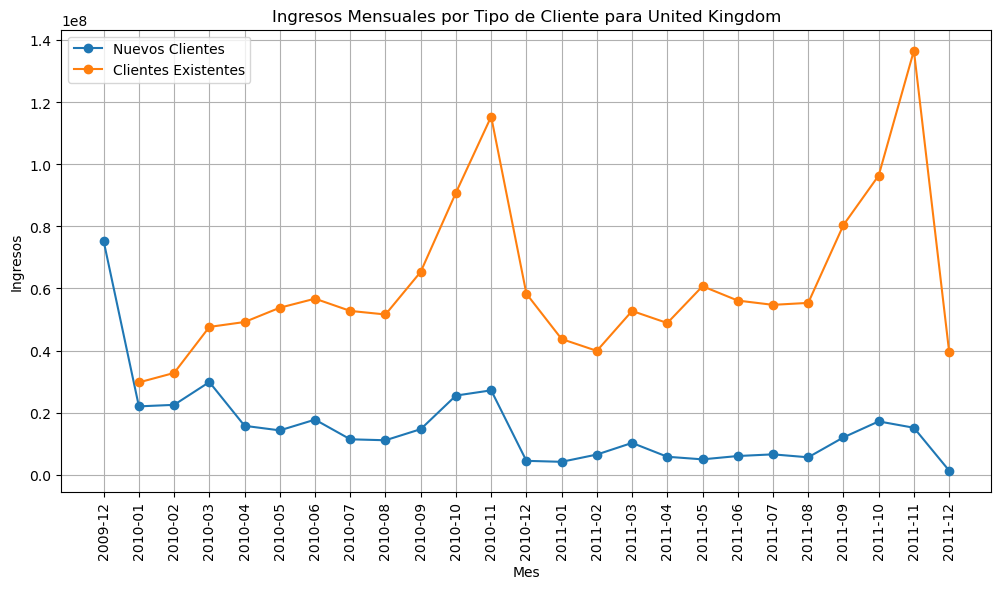

In [185]:
# Graficar los ingresos mensuales por tipo de cliente
plt.figure(figsize=(12, 6))

plt.plot(monthly_revenue_new['InvoiceYearMonth'].astype(str), 
         monthly_revenue_new['Revenue'], 
         label='Nuevos Clientes', marker='o')

plt.plot(monthly_revenue_existing['InvoiceYearMonth'].astype(str), 
         monthly_revenue_existing['Revenue'], 
         label='Clientes Existentes', marker='o')

plt.xlabel('Mes')
plt.ylabel('Ingresos')
plt.title(f'Ingresos Mensuales por Tipo de Cliente para {top_country}')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

<div style="background-color: AliceBlue; padding: 10px;"> Los gráficos indican que la adquisición de nuevos clientes parece ser constante, pero los ingresos generados por estos clientes son significativamente menores que los generados por los clientes existentes. Esto podría indicar que los nuevos clientes están realizando compras de menor valor o que las estrategias de adquisición no están atrayendo a clientes de alto valor. Los clientes existentes generan ingresos significativamente mayores, lo que sugiere una alta fidelización y retención.

## Actividad 2: Modelo predicción CLTV

Para realizar esta actividad se recomienda utilizar el módulo ensemble de `sklearn` y los paquetes `xgboost` y `lightgbm`, que contiene implementaciones de los principales algoritmos a utilizar.

### a. Ingeniería de características

Partiendo del dataset del apartado c correspondiente a los registros del país con más transacciones, entrenaremos el modelo con 12 meses y lo usaremos para predecir los próximos 6 meses.


i. Recogemos en 
* **dataset_12m** el periodo de `01-junio-2010` hasta `01-junio-2011` y 
* **dataset_6m** de `01-junio-2011` hasta `01-dic-2011`

In [186]:
# Filtrar el dataset para el periodo de 01-junio-2010 a 01-junio-2011
dataset_12m = top_country_data[(top_country_data['InvoiceDate'] >= '2010-06-01') & 
                               (top_country_data['InvoiceDate'] < '2011-06-01')]

# Filtrar el dataset para el periodo de 01-junio-2011 a 01-dic-2011
dataset_6m = top_country_data[(top_country_data['InvoiceDate'] >= '2011-06-01') & 
                              (top_country_data['InvoiceDate'] < '2011-12-01')]

ii. Cogemos los clientes distintos de `dataset_12m` y calculamos los valores de `frequency`, `recency` y `revenue` de cada cliente **Análisis RFM**, una técnica de marketing que se utiliza para encontrar a los mejores clientes analizando su comportamiento de compra en el pasado. Incluye la frecuencia con la que han comprado, el importe total que han gastado hasta ahora, la última vez que compraron en nuestra tienda online, etc.


Con el apoyo del paquete lifetimes y de la función summary_data_from_transaction_data tenéis que calcular los valores de las métricas RFM para cada uno de los clientes añadiendo las variables CustomerID, InvoiceDate y Revenue= cantidad de productos vendidos * precio unidad guardando los datos en un dataframe para el modelo.

In [187]:
from lifetimes.utils import summary_data_from_transaction_data

# Calcular las métricas RFM para dataset_12m
rfm_12m = summary_data_from_transaction_data(
    dataset_12m, 
    'Customer ID', 
    'InvoiceDate', 
    monetary_value_col='Revenue', 
    observation_period_end='2011-06-01'
)

# Mostrar las primeras filas del DataFrame RFM
print("Métricas RFM para dataset_12m:")
rfm_12m.head()


Métricas RFM para dataset_12m:


,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,3.0,204.0,338.0,13428.516667
12608.0,0.0,0.0,213.0,0.000000
12745.0,0.0,0.0,295.0,0.000000
12746.0,1.0,13.0,349.0,477.120000
12747.0,13.0,346.0,353.0,22535.421538


1. Mediante el módulo displot de seaborn debéis representar gráficamente la distribución de frequency, recency y monetary value obtenidos. ¿Qué conclusiones sacas?

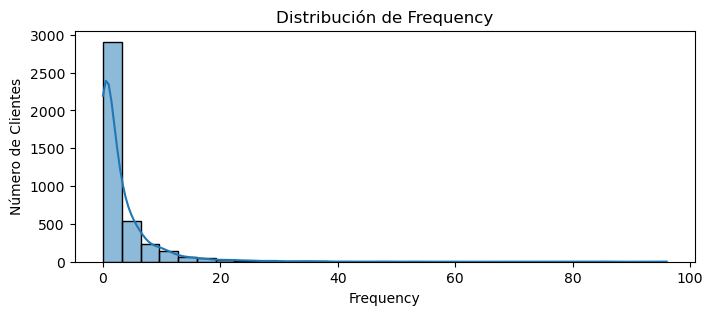

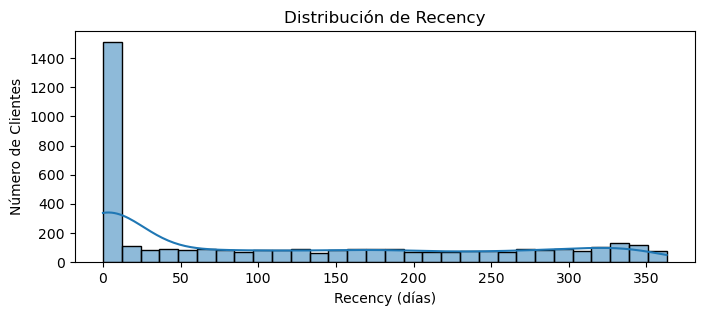

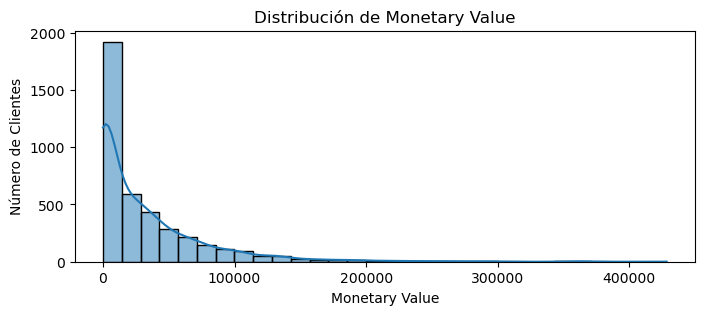

In [188]:

# Distribución de la frecuencia
plt.figure(figsize=(8, 3))
sns.histplot(rfm_12m['frequency'], bins=30, kde=True)
plt.title('Distribución de Frequency')
plt.xlabel('Frequency')
plt.ylabel('Número de Clientes')
plt.show()

# Distribución de la recencia
plt.figure(figsize=(8, 3))
sns.histplot(rfm_12m['recency'], bins=30, kde=True)
plt.title('Distribución de Recency')
plt.xlabel('Recency (días)')
plt.ylabel('Número de Clientes')
plt.show()

# Distribución del valor monetario
plt.figure(figsize=(8, 3))
sns.histplot(rfm_12m['monetary_value'], bins=30, kde=True)
plt.title('Distribución de Monetary Value')
plt.xlabel('Monetary Value')
plt.ylabel('Número de Clientes')
plt.show()

<div style="background-color: AliceBlue; padding: 10px;"> 

**Distribución de Frequency**: La mayoría de los clientes compran pocas veces, mucha gente realiza solo una o dos compras. Unos pocos clientes realizan compras frecuentes.

**Distribución de Recency**: Muchos clientes han realizado compras recientemente, pero también hay una cantidad significativa de clientes cuya última compra fue hace mucho tiempo. La recencia baja es un buen indicador de actividad reciente, pero la cola larga sugiere que hay clientes inactivos.

**Distribución de Monetary Value**: La mayoría de los clientes generan ingresos bajos, mientras que unos pocos generan ingresos muy altos.
Esto es típico en muchos negocios, donde unos pocos clientes de alto valor tienen un impacto desproporcionado en los ingresos totales.


2. A continuación, debéis agregar tres variables que clasifiquen al cliente en función de su frequency, recency y monetary value. Podéis utilizar KMeans para agrupar a los clientes en clusters y obtener un scoring por recency, frequency and monetary value.

In [189]:
# 'rfm_12m' ya está calculado y contiene las métricas RFM
rfm_12m = rfm_12m[['frequency', 'recency', 'monetary_value']]

# Escalar los datos
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_12m)

# Verificar los datos escalados
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['frequency', 'recency', 'monetary_value']).head()
rfm_scaled_df

,frequency,recency,monetary_value
0,-0.039773,0.689191,-0.405355
1,-0.538873,-0.958476,-0.698785
2,-0.538873,-0.958476,-0.698785
3,-0.372507,-0.853477,-0.688360
4,1.623893,1.836097,-0.206358


In [190]:
rfm_scaled_df.describe()

,frequency,recency,monetary_value
count,5.000000,5.000000,5.000000
mean,0.026773,-0.049028,-0.539529
std,0.915773,1.264910,0.224656
min,-0.538873,-0.958476,-0.698785
25%,-0.538873,-0.958476,-0.698785
50%,-0.372507,-0.853477,-0.688360
75%,-0.039773,0.689191,-0.405355
max,1.623893,1.836097,-0.206358


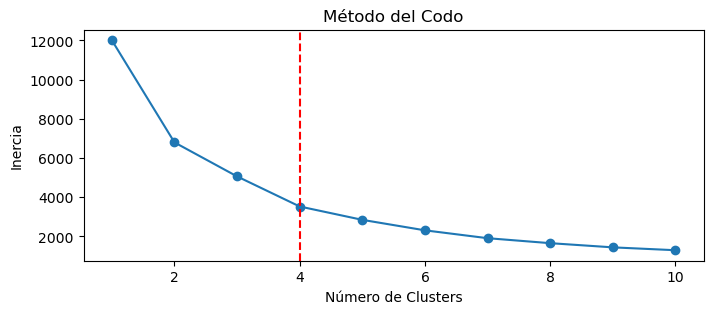

El número óptimo de clusters es: 4


In [191]:
# Aplicar KMeans para agrupar a los clientes

# Determinar el número óptimo de clusters usando el método del codo
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Usar kneed para encontrar el codo
kneedle = KneeLocator(range(1, 11), sse, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

# Graficar el método del codo
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), sse, marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

print(f'El número óptimo de clusters es: {optimal_k}')


**Crear y asignar los clusters**

In [192]:
# Crear el modelo KMeans con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_12m['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Calcular la media de cada Cluster
cluster_means = rfm_12m.groupby('Cluster').mean()

# Verificar clusters asignados y las medias calculadas
print("Cluster Means:")
print(cluster_means)

Cluster Means:
         frequency     recency  monetary_value
Cluster                                       
0         0.696468   23.751453     9039.334356
1         5.697205  253.117236    38918.626147
2         3.157623  168.708010   138786.469071
3        31.296703  336.263736    43452.128831


<div style="background-color: AliceBlue; padding: 10px;"> 

* **Cluster 0**: Representa a los clientes con baja frecuencia, recencia cercana y bajo valor monetario.
* **Cluster 1**: Clientes con frecuencia media, recencia alta y valor monetario moderado.
* **Cluster 2**: Clientes con frecuencia media-alta, recencia media y alto valor monetario.
* **Cluster 3**: Clientes con alta frecuencia, recencia muy alta y valor monetario moderado.

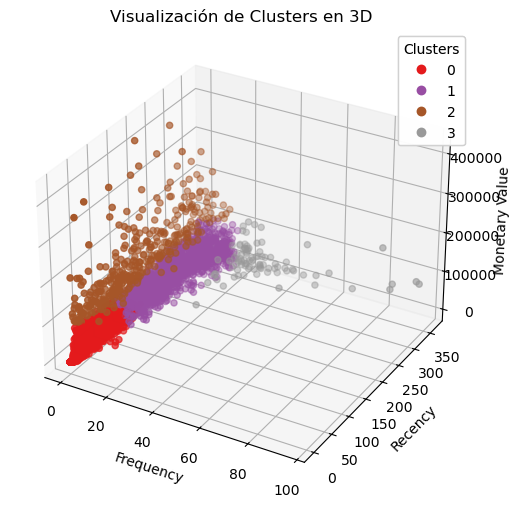

In [193]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(rfm_12m['frequency'], 
                     rfm_12m['recency'], 
                     rfm_12m['monetary_value'], 
                     c=rfm_12m['Cluster'], 
                     cmap='Set1')

ax.set_title('Visualización de Clusters en 3D')
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary Value')
legend1 = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend1)
plt.show()


**Asignar un scoring basado en los clusters**

Este código realiza las siguientes operaciones:

* Agrupación por Cluster: Agrupa el DataFrame rfm_12m por la columna Cluster.
* Cálculo de la media: Calcula la media de las columnas frequency, recency y monetary_value para cada cluster.
* Clasificación (rank): Clasifica los promedios calculados. La opción method='dense' asegura que los rangos sean consecutivos.
* Conversión a enteros: Convierte los rangos a enteros.

In [194]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar los valores escalados
scaler = MinMaxScaler()
rfm_normalized = scaler.fit_transform(rfm_scaled)

# Convertir los datos normalizados a DataFrame
rfm_normalized_df = pd.DataFrame(rfm_normalized, columns=['frequency', 'recency', 'monetary_value'])

# Crear un DataFrame auxiliar para el scoring utilizando datos normalizados
rfm_normalized_ranked = rfm_normalized_df.rank(method='dense').astype(int)
rfm_normalized_ranked.columns = ['FrequencyScore', 'RecencyScore', 'MonetaryScore']

# Unir los scores normalizados al DataFrame original (asegurándonos de mantener los IDs y Clusters)
rfm_12m.reset_index(inplace=True)
rfm_12m_scored_normalized = pd.concat([rfm_12m, rfm_normalized_ranked], axis=1)

# Verificar los resultados
print("\nRFM Scored Data (Normalized and Ranked) (first 10 rows):")
rfm_12m_scored_normalized.head(10)



RFM Scored Data (Normalized and Ranked) (first 10 rows):


,Customer ID,frequency,recency,monetary_value,Cluster,FrequencyScore,RecencyScore,MonetaryScore
0,12346.0,3.0,204.0,13428.516667,1,4,205,568
1,12608.0,0.0,0.0,0.000000,0,1,1,1
2,12745.0,0.0,0.0,0.000000,0,1,1,1
3,12746.0,1.0,13.0,477.120000,0,2,14,26
4,12747.0,13.0,346.0,22535.421538,1,14,347,955
5,12748.0,96.0,362.0,76377.942500,3,52,363,2186
6,12749.0,7.0,321.0,64629.875714,1,8,322,2025
7,12777.0,0.0,0.0,0.000000,0,1,1,1
8,12819.0,0.0,0.0,0.000000,0,1,1,1
9,12820.0,3.0,178.0,26995.430000,1,4,179,1135


**Añadir los scores al DataFrame original**

3. Por último, asigna una puntuación global “TotalScore” sumando las puntuaciones de las tres agrupaciones (“FrequencyCluster”, “RecencyCluster”,”RevenueCluster”). A partir de sus valores, debéis crear una variable del segmento valor alto, medio o bajo y redactar las características que presenta cada grupo de clientes. ¿Cuáles serían los cluster para estrategias de retención?
   
   Se sugiere llegar a obtener una agrupación de valor alto, medio y bajo para ello debéis modificar el código para que los clusters salgan ordenados en función del valor de su métrica, de tal forma que el cluster 0 siempre sea el peor de la clasificación.

**Calcular los Scores y Asignar la Puntuación Global**

In [195]:
# Crear la puntuación total sumando las puntuaciones de las tres agrupaciones
rfm_12m_scored_normalized['TotalScore'] = rfm_12m_scored_normalized['FrequencyScore'] + rfm_12m_scored_normalized['RecencyScore'] + rfm_12m_scored_normalized['MonetaryScore']
rfm_12m_scored_normalized.head()

,Customer ID,frequency,recency,monetary_value,Cluster,FrequencyScore,RecencyScore,MonetaryScore,TotalScore
0,12346.0,3.0,204.0,13428.516667,1,4,205,568,777
1,12608.0,0.0,0.0,0.000000,0,1,1,1,3
2,12745.0,0.0,0.0,0.000000,0,1,1,1,3
3,12746.0,1.0,13.0,477.120000,0,2,14,26,42
4,12747.0,13.0,346.0,22535.421538,1,14,347,955,1316


**Crear la Variable del Segmento de Valor**

In [196]:
# Crear segmentos basados en los tercios de TotalScore
score_bins = [rfm_12m_scored_normalized['TotalScore'].min()-1, 
              rfm_12m_scored_normalized['TotalScore'].quantile(0.33), 
              rfm_12m_scored_normalized['TotalScore'].quantile(0.66), 
              rfm_12m_scored_normalized['TotalScore'].max()]

score_labels = ['Low', 'Medium', 'High']

rfm_12m_scored_normalized['Segment'] = pd.cut(rfm_12m_scored_normalized['TotalScore'], bins=score_bins, labels=score_labels)

# Verificar los datos segmentados
rfm_12m_ = rfm_12m_scored_normalized[['Customer ID', 'FrequencyScore', 
                                     'RecencyScore', 'MonetaryScore', 
                                     'TotalScore', 'Segment']]
rfm_12m_.tail(10)

,Customer ID,FrequencyScore,RecencyScore,MonetaryScore,TotalScore,Segment
3993,18273.0,1,1,1,3,Low
3994,18276.0,4,135,1052,1191,Medium
3995,18277.0,6,177,757,940,Medium
3996,18278.0,1,1,1,3,Low
3997,18279.0,1,1,1,3,Low
3998,18280.0,3,118,748,869,Medium
3999,18283.0,7,278,2482,2767,High
4000,18284.0,2,3,16,21,Medium
4001,18286.0,2,58,2450,2510,High
4002,18287.0,3,244,1787,2034,High


<div style="background-color: AliceBlue; padding: 10px;"> 

**Características de Cada Grupo de Clientes**:

Valor Bajo (Low):

* Frecuencia baja: Estos clientes compran raramente.
* Recencia alta: Han pasado mucho tiempo desde su última compra.
* Valor monetario bajo: Gastan poco en sus compras.

Valor Medio (Medium):

* Frecuencia moderada: Compran con una frecuencia media.
* Recencia moderada: Han comprado en el pasado reciente, pero no son los más recientes.
* Valor monetario moderado: Gastan una cantidad moderada en sus compras.

Valor Alto (High):

* Alta frecuencia: Compran frecuentemente.
* Baja recencia: Han comprado recientemente.
* Alto valor monetario: Gastan mucho en sus compras.


iii. Como no tenemos ningún coste específico en nuestro conjunto de datos, la variable LTV a predecir es `Revenue`. Para el **dataset_6m**, calculamos para cada cliente los ingresos agregados de los próximos 6 meses y con la función merge agregamos la puntuación al dataset para el modelo a nivel cliente rellenando los `NA’s` como 0.

In [197]:
# Calcular los ingresos agregados de los próximos 6 meses para cada cliente
ltv_6m = dataset_6m.groupby('Customer ID')['Revenue'].sum().reset_index()
ltv_6m.columns = ['Customer ID', 'LTV']
ltv_6m.tail()


,Customer ID,LTV
3162,18278.0,35344.07
3163,18281.0,28913.13
3164,18282.0,25881.00
3165,18283.0,1245932.79
3166,18287.0,79309.54


In [198]:
# Eliminar filas duplicadas basadas en 'Customer ID' en dataset_6m
dataset_6m_unique = dataset_6m.drop_duplicates(subset=['Customer ID'])

# Merge de dataset_6m_unique con las puntuaciones calculadas de rfm_12m_
dataset_6m_unique = dataset_6m_unique.merge(rfm_12m_, on='Customer ID', how='left')

# Merge del dataset con el LTV calculado
dataset_6m_unique = dataset_6m_unique.merge(ltv_6m, on='Customer ID', how='left')

# Rellenar los NA's como 0
dataset_6m_unique['LTV'].fillna(0, inplace=True)


print("\nDataset con LTV de los próximos 6 meses:")
dataset_6m_unique[['Customer ID', 'FrequencyScore', 
                   'RecencyScore', 'MonetaryScore', 
                   'TotalScore', 'Segment', 'Revenue']].head()



Dataset con LTV de los próximos 6 meses:


,Customer ID,FrequencyScore,RecencyScore,MonetaryScore,TotalScore,Segment,Revenue
0,15643.0,1.0,1.0,1.0,3.0,Low,1709.76
1,14842.0,2.0,7.0,32.0,41.0,Medium,1677.78
2,15124.0,1.0,1.0,1.0,3.0,Low,3622.30
3,16422.0,48.0,359.0,758.0,1165.0,Medium,1762.56
4,15240.0,12.0,292.0,716.0,1020.0,Medium,1318.90


**Agregar las puntuaciones calculadas al dataset_6m**

In [199]:
# Unir el revenue de los próximos 6 meses al dataset de puntuación
dataset_6m_final = rfm_12m_.merge(ltv_6m, on='Customer ID', how='left')

# Rellenar los NA's como 0
dataset_6m_final['LTV'].fillna(0, inplace=True)
dataset_6m_final.tail(10)

,Customer ID,FrequencyScore,RecencyScore,MonetaryScore,TotalScore,Segment,LTV
3993,18273.0,1,1,1,3,Low,2637.17
3994,18276.0,4,135,1052,1191,Medium,29357.63
3995,18277.0,6,177,757,940,Medium,19331.16
3996,18278.0,1,1,1,3,Low,35344.07
3997,18279.0,1,1,1,3,Low,0.00
3998,18280.0,3,118,748,869,Medium,0.00
3999,18283.0,7,278,2482,2767,High,1245932.79
4000,18284.0,2,3,16,21,Medium,0.00
4001,18286.0,2,58,2450,2510,High,0.00
4002,18287.0,3,244,1787,2034,High,79309.54


iv. Eliminamos del dataset del modelo los outliers de los clientes que tienen una Revenue elevada los próximos 6 meses y creamos una variable categórica, que agrupe a los clientes en 3 clusters según el valor de LTV “LTVCluster”, ordenándolos de forma ascendente según el valor de Revenue. Será la variable objetivo.
Podéis añadir las variables que consideréis para predecir la calidad del cliente.

In [200]:
# Calcular el IQR para la columna LTV
Q1 = dataset_6m_final['LTV'].quantile(0.25)
Q3 = dataset_6m_final['LTV'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los datos eliminando los outliers
dataset_6m_no_outliers = dataset_6m_final[(dataset_6m_final['LTV'] >= lower_bound) & 
                                          (dataset_6m_final['LTV'] <= upper_bound)]

# Verificar los datos después de eliminar los outliers
dataset_6m_no_outliers[['Customer ID', 'LTV']].describe()


,Customer ID,LTV
count,3630.000000,3630.000000
mean,15546.494766,50984.407055
std,1583.384568,73450.207391
min,12346.000000,0.000000
25%,14176.250000,0.000000
50%,15575.500000,6989.435000
75%,16920.750000,82906.092500
max,18287.000000,301272.170000


In [201]:
# Crear clusters basados en tercios de LTV
ltv_bins = [dataset_6m_no_outliers['LTV'].min()-1, 
            dataset_6m_no_outliers['LTV'].quantile(0.33), 
            dataset_6m_no_outliers['LTV'].quantile(0.66), 
            dataset_6m_no_outliers['LTV'].max()]

ltv_labels = ['Low', 'Medium', 'High']

dataset_6m_no_outliers['LTVCluster'] = pd.cut(dataset_6m_no_outliers['LTV'], bins=ltv_bins, labels=ltv_labels)

# Verificar los datos segmentados
print("\nDataset con LTVCluster:")
dataset_6m_no_outliers[['Customer ID', 'LTV', 'LTVCluster']].head(10)


Dataset con LTVCluster:


,Customer ID,LTV,LTVCluster
0,12346.0,0.00,Low
1,12608.0,0.00,Low
2,12745.0,0.00,Low
3,12746.0,0.00,Low
4,12747.0,100094.54,High
7,12777.0,0.00,Low
8,12819.0,0.00,Low
9,12820.0,97295.03,High
10,12821.0,0.00,Low
11,12823.0,8387.50,Medium


In [202]:
# Añadir Variables para Predecir la Calidad del Cliente
final_dataset = dataset_6m_no_outliers[['Customer ID', 'FrequencyScore', 'RecencyScore', 
                                        'MonetaryScore', 'TotalScore', 'Segment', 
                                        'LTV', 'LTVCluster']]
final_dataset.head()

,Customer ID,FrequencyScore,RecencyScore,MonetaryScore,TotalScore,Segment,LTV,LTVCluster
0,12346.0,4,205,568,777,Medium,0.00,Low
1,12608.0,1,1,1,3,Low,0.00,Low
2,12745.0,1,1,1,3,Low,0.00,Low
3,12746.0,2,14,26,42,Medium,0.00,Low
4,12747.0,14,347,955,1316,Medium,100094.54,High


v. Utilizando la librería get_dummies convertimos las variables categóricas y observamos las variables correlacionadas con el scoring LTV “LTVCluster”. 
* Definimos nuestro conjunto de variables explicativas, eliminando la variable a predecir “LTVCluster” y el revenue de los próximos 6 meses.

In [203]:
# Convertir las variables categóricas a variables dummy
final_dataset_dummies = pd.get_dummies(final_dataset, columns=['Segment'], 
                                       drop_first=False) 

# Establecer Customer ID como índice
final_dataset_dummies.set_index('Customer ID', inplace=True)

# Verificar el dataset con dummies
final_dataset_dummies.head()

,FrequencyScore,RecencyScore,MonetaryScore,TotalScore,LTV,LTVCluster,Segment_Low,Segment_Medium,Segment_High
Customer ID,,,,,,,,,
12346.0,4,205,568,777,0.00,Low,False,True,False
12608.0,1,1,1,3,0.00,Low,True,False,False
12745.0,1,1,1,3,0.00,Low,True,False,False
12746.0,2,14,26,42,0.00,Low,False,True,False
12747.0,14,347,955,1316,100094.54,High,False,True,False


In [204]:
# Convertir LTVCluster a variable numérica para calcular la correlación
final_dataset_dummies['LTVCluster'] = final_dataset_dummies['LTVCluster'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Calcular la correlación
correlation_matrix = final_dataset_dummies.corr()

# Ver las correlaciones con LTVCluster
correlation_with_ltvcluster = correlation_matrix['LTVCluster'].sort_values(ascending=False)
correlation_with_ltvcluster

LTVCluster        1.000000
LTV               0.813410
RecencyScore      0.416302
TotalScore        0.377364
FrequencyScore    0.377214
MonetaryScore     0.351596
Segment_High      0.294667
Segment_Medium    0.050371
Segment_Low      -0.328372
Name: LTVCluster, dtype: float64

<div style="background-color: AliceBlue; padding: 10px;">

* **LTVCluster**: es la variable objetivo.
* **LTV**: Tiene una alta correlación con LTVCluster (0.841879), lo que indica que LTV es una buena medida para predecir LTVCluster.
* **MonetaryScore**: Tiene una correlación positiva con LTVCluster (0.252174), lo que sugiere que a medida que el valor monetario del cliente aumenta, es más probable que pertenezca a un cluster con mayor LTVCluster.
* **ValueSegment_High**: Correlación positiva (0.245111), indicando que los clientes en el segmento de alto valor tienden a tener un LTVCluster más alto.
* **TotalScore, FrequencyScore, RecencyScore**: Todas estas variables muestran una correlación positiva con LTVCluster, aunque no tan alta como LTV.
* **ValueSegment_Low**: Correlación negativa (-0.140501), indicando que los clientes en el segmento de bajo valor tienden a tener un LTVCluster más bajo.

In [205]:
# Definir el conjunto de variables explicativas
features = final_dataset_dummies.drop(columns=['LTVCluster', 'LTV'])

# Verificar las variables explicativas
features.head()

,FrequencyScore,RecencyScore,MonetaryScore,TotalScore,Segment_Low,Segment_Medium,Segment_High
Customer ID,,,,,,,
12346.0,4,205,568,777,False,True,False
12608.0,1,1,1,3,True,False,False
12745.0,1,1,1,3,True,False,False
12746.0,2,14,26,42,False,True,False
12747.0,14,347,955,1316,False,True,False


vi. Para la visualización de datos, representaremos con el módulo pairplot el comportamiento de cada variable frente a la variable objetivo.

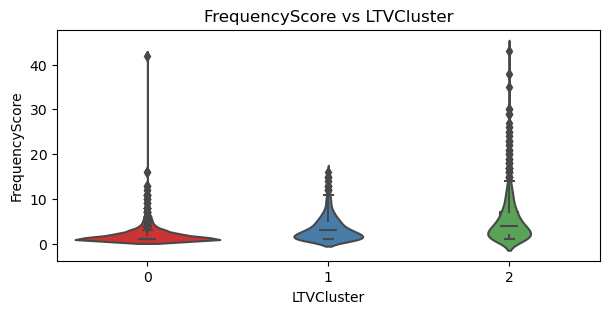

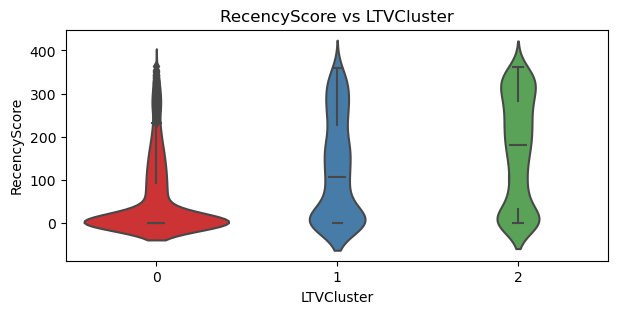

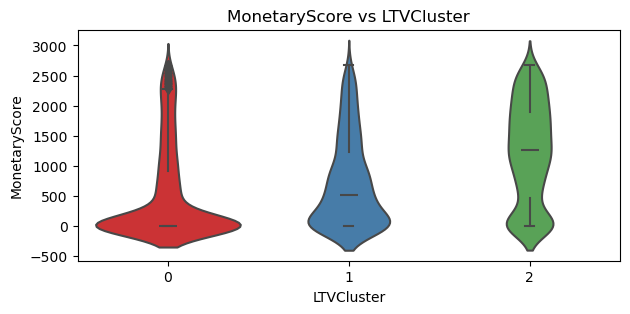

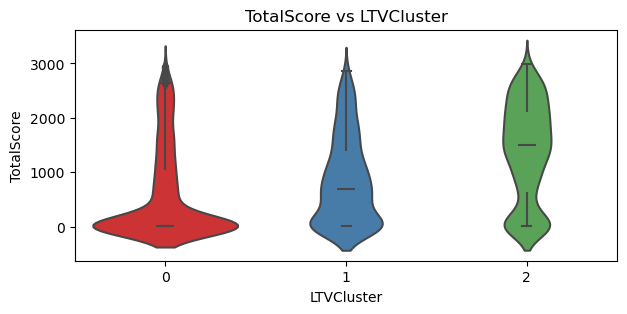

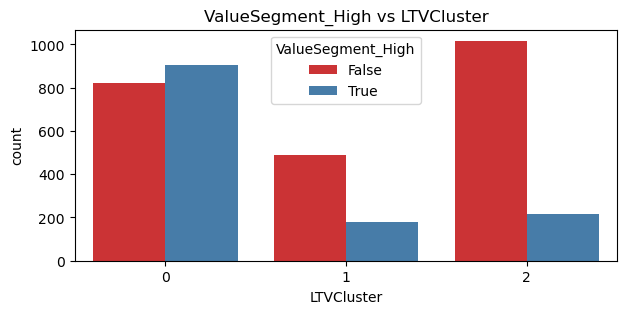

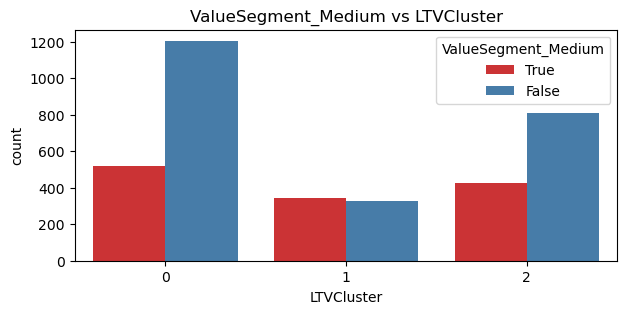

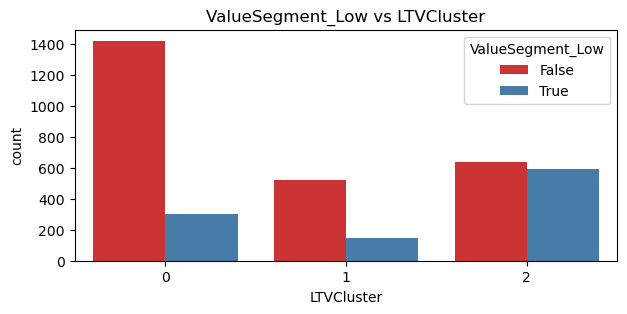

In [206]:
# Convertir las variables de segmento a cadenas para la visualización
final_dataset_dummies['ValueSegment_High'] = final_dataset_dummies['Segment_Low'].map({True: 'True', False: 'False'})
final_dataset_dummies['ValueSegment_Medium'] = final_dataset_dummies['Segment_Medium'].map({True: 'True', False: 'False'})
final_dataset_dummies['ValueSegment_Low'] = final_dataset_dummies['Segment_High'].map({True: 'True', False: 'False'})

# Seleccionar las variables explicativas y la variable objetivo para la visualización
data_for_pairplot = final_dataset_dummies.reset_index()[['FrequencyScore', 'RecencyScore', 
                                                         'MonetaryScore', 'TotalScore', 
                                                         'ValueSegment_High', 'ValueSegment_Low', 
                                                         'ValueSegment_Medium','LTVCluster']]

# List of continuous variables
variables_continuas = ['FrequencyScore', 'RecencyScore', 'MonetaryScore', 'TotalScore']

# Create combined violin and box plots for each continuous variable
for var in variables_continuas:
    plt.figure(figsize=(7, 3))
    sns.violinplot(x='LTVCluster', y=var, data=data_for_pairplot, inner=None, palette='Set1')
    sns.boxplot(x='LTVCluster', y=var, data=data_for_pairplot, whis=1.5, width=0.1, palette='Set1')
    plt.title(f'{var} vs LTVCluster')
    plt.show()

# Create count plots for categorical variables
categorical_vars = ['ValueSegment_High', 'ValueSegment_Medium', 'ValueSegment_Low']

for var in categorical_vars:
    plt.figure(figsize=(7, 3))
    sns.countplot(x='LTVCluster', hue=var, data=data_for_pairplot, palette='Set1')
    plt.title(f'{var} vs LTVCluster')
    plt.show()

### b. XGBoost

A diferencia de las implementaciones nativas de scikit-learn, en XGBoost, el conjunto de validación para la parada temprana no se extrae automáticamente. Para poder integrar la parada temprana con el `GridSearchCV()` o `RandomizedSearchCV()` y que no haya observaciones que participen en ambos procesos, se tiene que separar manualmente un conjunto de validación del de entrenamiento. https://xgboost.readthedocs.io/en/latest/python/python_api.html

Es necesario realizar los siguientes pasos:


i. Crear conjunto de validación con un peso del 5%, sin reemplazamiento.  
ii. Construir un diccionario para el grid de hiperparámetros con validación cruzada:
* **max_depth**: suele ser un valor muy bajo, haciendo así que cada árbol solo pueda aprender una pequeña parte de la relación entre predictores y variable respuesta. Se recomienda probar con valores cercanos al 6
* **subsample**: proporción de observaciones utilizadas para el ajuste de cada árbol. Si su valor es inferior a 1, se está aplicando Stochastic Gradient Boosting. Se recomienda probar con valores cercanos al 0.5
* **learning_rate**: permite controlar cómo de rápido aprende el modelo y el riesgo a llegar al overfitting. Cuanto menor es, más árboles se necesitan para alcanzar buenos resultados pero menor es el riesgo de overfitting. Se recomienda probar con valores cercanos al 0.1
* **objetive**: “multi:softprob” al ser un modelo de multiclasificación 
* **num_class**: no de clases a predecir en la variable objetivo, 3 en nuestro caso.
* **n_estimators**: proporción de observaciones utilizadas para el ajuste de cada árbol. Se recomienda incluir >1000
  
iii. Se realiza búsqueda GridSearchCV por validación cruzada incluyendo como estimator=XGBClassifier. Se recomienda incluir random_state=56 para que los resultados sean reproducibles.

**División de Datos**

In [207]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

X = features
y = final_dataset_dummies['LTVCluster']

# Dividir el conjunto de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=56)

**Configuración y Entrenamiento de Modelos**

In [208]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Configurar el diccionario para el grid de hiperparámetros
param_grid_xgb = {
    'max_depth': [6],
    'subsample': [0.5],
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'objective': ['multi:softprob'],
    'num_class': [3]
}

# Crear el modelo XGBClassifier
xgb_model = XGBClassifier(random_state=56, early_stopping_rounds=10)

# Entrenar el modelo incluyendo el conjunto de validación
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Mejor hiperparámetro encontrado
print(f"Mejores hiperparámetros para XGBoost: {grid_search_xgb.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores hiperparámetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000, 'num_class': 3, 'objective': 'multi:softprob', 'subsample': 0.5}


In [209]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_xgb = grid_search_xgb.predict(X_val)
y_val_proba_xgb = grid_search_xgb.predict_proba(X_val)

# Definir función para calcular métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y_true, y_pred, y_proba):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1 Score': f1_score(y_true, y_pred, average='weighted'),
        'AUC ROC': roc_auc_score(y_true, y_proba, multi_class='ovo', average='weighted')
    }
    return metrics

# Obtener métricas para XGBoost
val_metrics_xgb = calculate_metrics(y_val, y_val_pred_xgb, y_val_proba_xgb)

# Guardar resultados en un DataFrame
metrics_df_xgb = pd.DataFrame(val_metrics_xgb, index=[0])
metrics_df_xgb

,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,0.604396,0.592858,0.604396,0.561719,0.702311


### c. Repite el apartado anterior, con Random Forest o LightGBM

In [210]:
from sklearn.ensemble import RandomForestClassifier

# Configurar el diccionario para el grid de hiperparámetros
param_grid_rf = {
    'n_estimators': [1000],
    'max_depth': [6],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# Crear el modelo RandomForestClassifier
rf_model = RandomForestClassifier(random_state=56)

# Entrenar el modelo
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Mejor hiperparámetro encontrado
print(f"Mejores hiperparámetros para RandomForest: {grid_search_rf.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Mejores hiperparámetros para RandomForest: {'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [211]:
# Evaluar el modelo en el conjunto de validación
y_val_pred_rf = grid_search_rf.predict(X_val)
y_val_proba_rf = grid_search_rf.predict_proba(X_val)

# Obtener métricas para RandomForest
val_metrics_rf = calculate_metrics(y_val, y_val_pred_rf, y_val_proba_rf)

# Guardar resultados en un DataFrame
metrics_df_rf = pd.DataFrame(val_metrics_rf, index=[0])
metrics_df_rf

,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,0.620879,0.645353,0.620879,0.576231,0.740536


   Accuracy  Precision    Recall  F1 Score   AUC ROC
0  0.410959   0.295572  0.410959  0.337078  0.566755

## d. Métricas de validación para los resultados obtenidos con el XGBoost

i. Calcula la importancia de los predictores por pureza de nodos a la hora de calcular la variable objetivo.

ii. Selecciona una muestra de clientes puntuados por los modelos e interpreta con el valor de sus característica porqué obtienen el valor predicciones ShapValues

iii. Obtén las siguientes métricas de evaluación para la muestra de entrenamiento y de test de cada modelo: accuracy, precision, recall, AUC_ROC, F1 Test.

iv. A continuación, debéis mostrar la matriz de confusión para los datos de entrenamiento y de test.

v. ¿Qué conclusiones puedes obtener para los resultados del modelo XGBoost?¿ Crees que el meta-modelo generaliza bien sin caer en el Overfitting? Justifica tu respuesta.


**Métricas de Validación para los Resultados Obtenidos con el XGB**

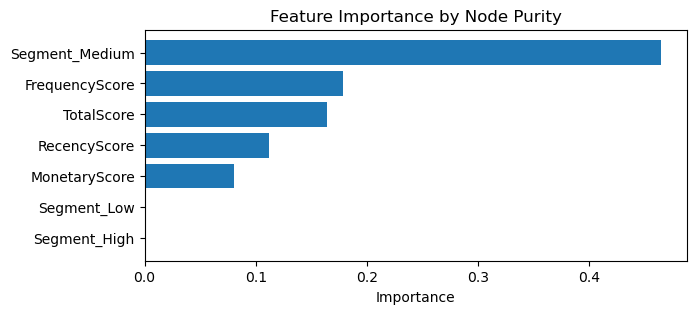

In [212]:
import xgboost as xgb

# Extraer la importancia de los predictores
importance = grid_search_xgb.best_estimator_.feature_importances_
features = X.columns

# Crear un DataFrame para visualizar la importancia
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Ordenar el DataFrame por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de los predictores
plt.figure(figsize=(7, 3))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance by Node Purity')
plt.gca().invert_yaxis()
plt.show()


**Interpretación de Predicciones con SHAP Values**

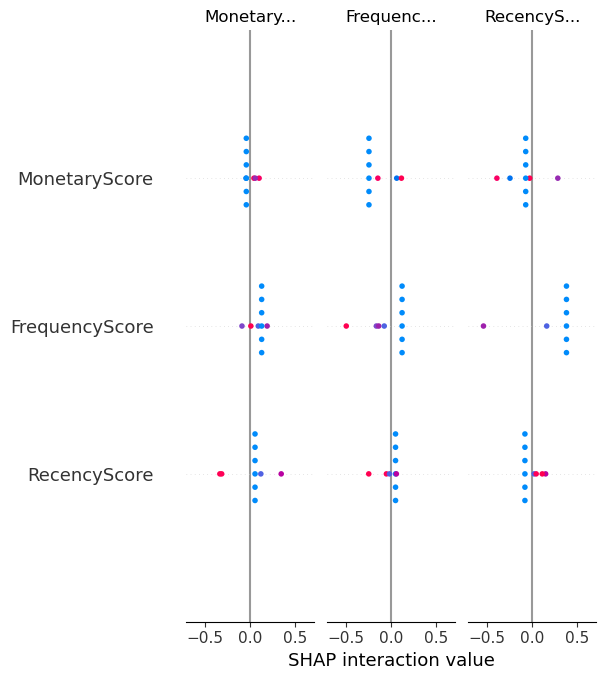

In [213]:
import shap


# Crear un objeto Explainer de SHAP para XGBoost
explainer = shap.Explainer(grid_search_xgb.best_estimator_)

np.random.seed(56)

# Seleccionar una muestra aleatoria de clientes
sample_indices = np.random.choice(X_val.index, size=10, replace=False)
sample_data = X_val.loc[sample_indices]

# Calcular los valores SHAP para la muestra
shap_values = explainer(sample_data)

# Visualizar los valores SHAP
shap.summary_plot(shap_values.values, features=sample_data, feature_names=sample_data.columns, plot_type="bar")


<div style="background-color: AliceBlue; padding: 10px;">

Cada punto representa un cliente, y el valor en el eje $Y$ muestra la contribución de una característica específica a la predicción del modelo. Las características incluidas son MonetaryScore, FrequencyScore y RecencyScore. La posición de los puntos en el eje $X$ muestra el valor de la característica en sí misma, y el color indica la intensidad del valor (rojo para alto, azul para bajo).

* **MonetaryScore**: Los puntos también están centrados en torno a cero en las interacciones con FrequencyScore y RecencyScore, indicando una interacción mínima en términos de impacto en la predicción..

* **FrequencyScore**: La mayoría de los puntos están centrados en torno a cero en las interacciones con MonetaryScore y RecencyScore, lo que sugiere que la interacción entre estas características y FrequencyScore no tiene un impacto significativo en la predicción..

* **RecencyScore**: Similarmente, los puntos están distribuidos cerca de cero en las interacciones con FrequencyScore y MonetaryScore, sugiriendo un impacto limitado de estas interacciones en la predicción final..

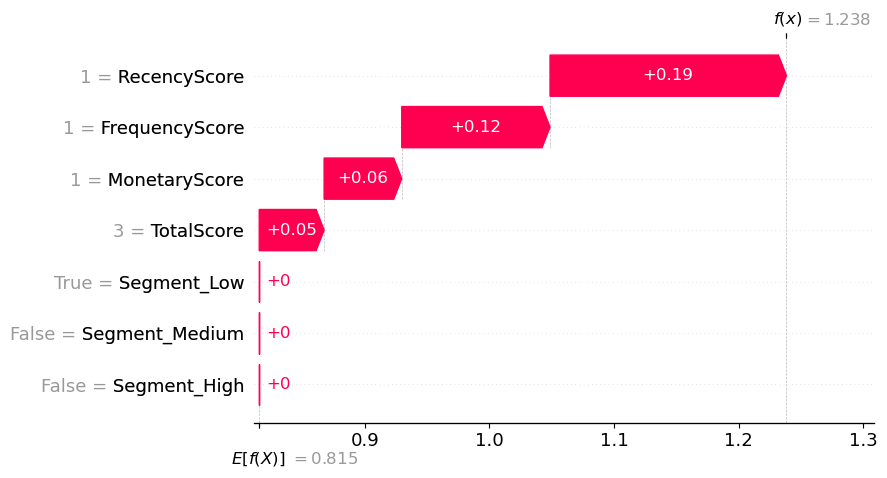

In [214]:
single_shap_value = shap_values[0]
single_shap_value_for_class = single_shap_value.values[:, 0]  # Seleccionar la explicación para la primera clase

shap.waterfall_plot(shap.Explanation(values=single_shap_value_for_class,
                                     base_values=single_shap_value.base_values[0],
                                     data=single_shap_value.data,
                                     feature_names=sample_data.columns))

<div style="background-color: AliceBlue; padding: 10px;">

El gráfico de fuerza SHAP muestra cómo cada característica contribuye a una predicción específica en comparación con la predicción promedio.

RecencyScore (1), FrequencyScore (1), MonetaryScore (1), y TotalScore (3) aumentan la predicción en 0.19, 0.12, 0.06 y 0.05 respectivamente. Estos valores muestran que cada una de estas características tiene un impacto positivo en la predicción final, elevando el valor desde el promedio de 0.815 hasta la predicción final de 1.238.

La predicción final del modelo para estos clientes es 1.238, después de sumar todas las contribuciones de las características al valor base.

**Métricas de Evaluación**

iii. Obtén las siguientes métricas de evaluación para la muestra de entrenamiento y de test de cada modelo: accuracy, precision, recall, AUC_ROC, F1 Test.

In [215]:
# Obtener las métricas de evaluación para la muestra de entrenamiento y de test de cada modelo
train_metrics_xgb = calculate_metrics(y_train, grid_search_xgb.predict(X_train), grid_search_xgb.predict_proba(X_train))
val_metrics_xgb = calculate_metrics(y_val, y_val_pred_xgb, y_val_proba_xgb)

train_metrics_rf = calculate_metrics(y_train, grid_search_rf.predict(X_train), grid_search_rf.predict_proba(X_train))
val_metrics_rf = calculate_metrics(y_val, y_val_pred_rf, y_val_proba_rf)

# Crear DataFrame para mostrar las métricas
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC ROC'],
    'RandomForest_Train': list(train_metrics_rf.values()),
    'RandomForest_Validation': list(val_metrics_rf.values()),
    'XGBoost_Train': list(train_metrics_xgb.values()),
    'XGBoost_Validation': list(val_metrics_xgb.values())
})

metrics_df

,Metric,RandomForest_Train,RandomForest_Validation,XGBoost_Train,XGBoost_Validation
0,Accuracy,0.645592,0.620879,0.670534,0.604396
1,Precision,0.645786,0.645353,0.678567,0.592858
2,Recall,0.645592,0.620879,0.670534,0.604396
3,F1 Score,0.612252,0.576231,0.639956,0.561719
4,AUC ROC,0.758953,0.740536,0.778847,0.702311


   Accuracy  Precision    Recall  F1 Score   AUC ROC
0  0.410959   0.295572  0.410959  0.337078  0.566755

<div style="background-color: AliceBlue; padding: 10px;">

Generalización

**RandomForest**: Muestra una mejor capacidad de generalización con métricas de validación más cercanas a las de entrenamiento.  
**XGBoost**: Aunque tiene un mejor rendimiento en el conjunto de entrenamiento, muestra una mayor disminución en el conjunto de validación, sugiriendo sobreajuste.

Precisión y Recall

**RandomForest**: Tiene una caída menor en precisión y recall entre los conjuntos de entrenamiento y validación, lo que indica que el modelo mantiene un buen balance.   
**XGBoost**: Tiene una mayor caída, lo que sugiere que el modelo podría estar ajustándose demasiado a los datos de entrenamiento.

F1 Score y AUC ROC:

**RandomForest**: Mantiene un mejor balance en F1 Score y AUC ROC entre entrenamiento y validación.  
**XGBoos**t: Muestra un mayor AUC ROC en el conjunto de entrenamiento pero cae significativamente en el conjunto de validación.

iv. A continuación, debéis mostrar la matriz de confusión para los datos de entrenamiento y de test.

In [216]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predecir con RandomForest en el conjunto de entrenamiento y validación
y_train_pred_rf = grid_search_rf.predict(X_train)
y_val_pred_rf = grid_search_rf.predict(X_val)

# Predecir con XGBoost en el conjunto de entrenamiento y validación
y_train_pred_xgb = grid_search_xgb.predict(X_train)
y_val_pred_xgb = grid_search_xgb.predict(X_val)


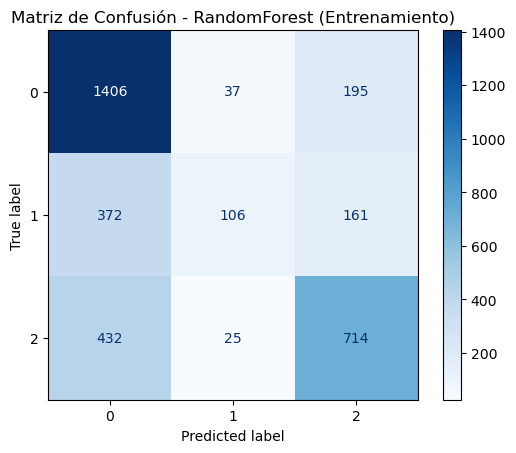

In [217]:
# Matriz de confusión para RandomForest (entrenamiento)
cm_rf_train = confusion_matrix(y_train, y_train_pred_rf)
disp_rf_train = ConfusionMatrixDisplay(confusion_matrix=cm_rf_train, display_labels=grid_search_rf.classes_)
disp_rf_train.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - RandomForest (Entrenamiento)")
plt.show()


<div style="background-color: AliceBlue; padding: 10px;">

Clase 0:

Verdaderos Positivos (TP): 1406  
Falsos Positivos (FP): 37 + 195 = 232  
Falsos Negativos (FN): 372 + 432 = 804  

Clase 1:

Verdaderos Positivos (TP): 106  
Falsos Positivos (FP): 37 + 25 = 62  
Falsos Negativos (FN): 372 + 161 = 533  

Clase 2:

Verdaderos Positivos (TP): 714  
Falsos Positivos (FP): 195 + 161 = 356  
Falsos Negativos (FN): 432 + 25 = 457  

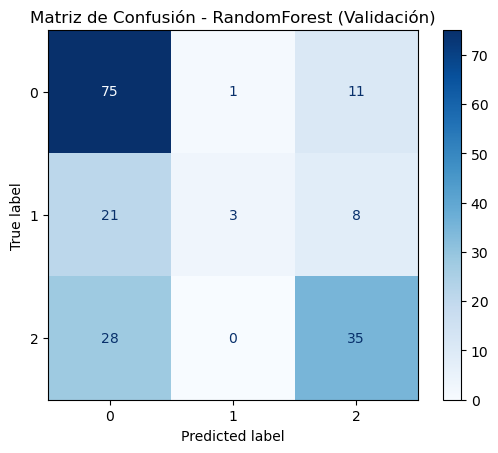

In [218]:
# Matriz de confusión para RandomForest (validación)
cm_rf_val = confusion_matrix(y_val, y_val_pred_rf)
disp_rf_val = ConfusionMatrixDisplay(confusion_matrix=cm_rf_val, display_labels=grid_search_rf.classes_)
disp_rf_val.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - RandomForest (Validación)")
plt.show()

<div style="background-color: AliceBlue; padding: 10px;">

Clase 0:

Verdaderos Positivos (TP): 75  
Falsos Positivos (FP): 1 + 11 = 12  
Falsos Negativos (FN): 21 + 28 = 49  

Clase 1:

Verdaderos Positivos (TP): 3    
Falsos Positivos (FP): 1 + 0 = 1  
Falsos Negativos (FN): 21 + 8 = 29  

Clase 2:

Verdaderos Positivos (TP): 35  
Falsos Positivos (FP): 11 + 8 = 19  
Falsos Negativos (FN): 28 + 0 = 28  

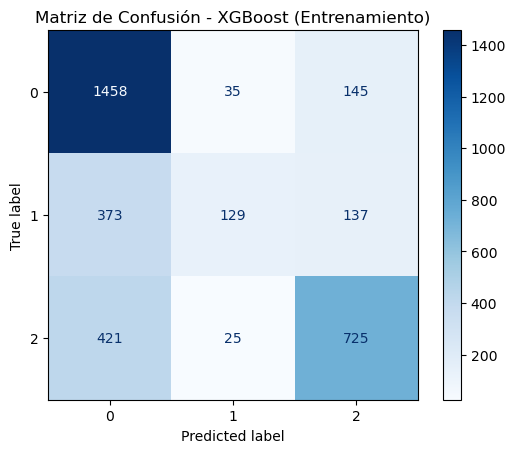

In [219]:
# Matriz de confusión para XGBoost (entrenamiento)
cm_xgb_train = confusion_matrix(y_train, y_train_pred_xgb)
disp_xgb_train = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_train, display_labels=grid_search_xgb.classes_)
disp_xgb_train.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - XGBoost (Entrenamiento)")
plt.show()


<div style="background-color: AliceBlue; padding: 10px;">

Clase 0:

Verdaderos Positivos (TP): 1458  
Falsos Positivos (FP): 35 + 145 = 180  
Falsos Negativos (FN): 373 + 421 = 794  

Clase 1:  

Verdaderos Positivos (TP): 129  
Falsos Positivos (FP): 35 + 25 = 60  
Falsos Negativos (FN): 373 + 137 = 510  

Clase 2:

Verdaderos Positivos (TP): 725  
Falsos Positivos (FP): 145 + 137 = 282  
Falsos Negativos (FN): 421 + 25 = 446  

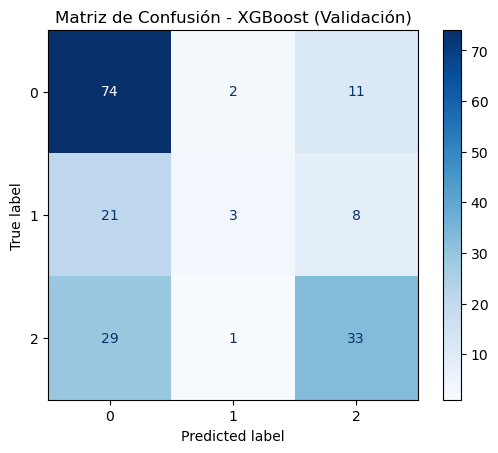

In [220]:
# Matriz de confusión para XGBoost (validación)
cm_xgb_val = confusion_matrix(y_val, y_val_pred_xgb)
disp_xgb_val = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_val, display_labels=grid_search_xgb.classes_)
disp_xgb_val.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - XGBoost (Validación)")
plt.show()

<div style="background-color: AliceBlue; padding: 10px;">


Clase 0:

Verdaderos Positivos (TP): 74  
Falsos Positivos (FP): 2 + 11 = 13  
Falsos Negativos (FN): 21 + 29 = 50  

Clase 1:

Verdaderos Positivos (TP): 3  
Falsos Positivos (FP): 2 + 1 = 3  
Falsos Negativos (FN): 21 + 8 = 29  

Clase 2:

Verdaderos Positivos (TP): 33  
Falsos Positivos (FP): 11 + 8 = 19  
Falsos Negativos (FN): 29 + 1 = 30  

### Conclusiones 

<div style="background-color: AliceBlue; padding: 10px;">

XGBoost tiene un mejor desempeño en el conjunto de entrenamiento, lo que indica un mejor ajuste inicial, pero pierde precisión en la validación.  
RandomForest muestra un rendimiento más consistente entre entrenamiento y validación, lo que sugiere una mejor capacidad de generalización.  

Interpretación de las Matrices de Confusión:  

Para la clase 0, ambos modelos muestran una cantidad significativa de verdaderos positivos, pero también tienen falsos negativos considerables.  
Para la clase 1, los verdaderos positivos son bajos en ambos conjuntos y modelos, lo que sugiere que esta clase es la más difícil de predecir correctamente.  
Para la clase 2, hay una mejor predicción en comparación con la clase 1, pero sigue habiendo un número considerable de falsos positivos y negativos.  

### Actividad 3: Gobernanza de grandes cantidades de datos

Las organizaciones son ricas en datos, que por lo general les cuesta transformar en un activo empresarial estratégico. Gracias a la gobernanza de los datos, las empresas pueden dotarse de una base sólida para extraer valor. Lee el siguiente artículo (Datos masivos y datos abiertos para una gobernanza inteligente) y contesta las siguientes preguntas:

● Crees que la gobernanza inteligente tiene más oportunidades en el sector privado que en el sector público?

<div style="background-color: AliceBlue; padding: 10px;">
La gobernanza inteligente tiene numerosas aplicaciones tanto en el sector público como en el privado. Sin embargo, la perspectiva del sector público se destaca más en el artículo, ya que subraya cómo las administraciones públicas pueden beneficiarse del uso de grandes volúmenes de datos para mejorar la toma de decisiones, la transparencia y la eficiencia en la prestación de servicios​​.

<br>


No obstante, en el sector privado, la gobernanza inteligente también tiene un enorme potencial, particularmente en términos de optimización de procesos, personalización de servicios y desarrollo de nuevos productos basados en el análisis de datos. Las empresas pueden utilizar grandes volúmenes de datos para identificar patrones de comportamiento del cliente, mejorar sus estrategias de marketing y optimizar la gestión de la cadena de suministro​​.
</div>

● En qué casos crees que podría ayudar la apertura de datos públicos a la ciudadanía a parte de lo comentado en el artículo? ¿Qué peligros podría entrañar dicha publicación?

<div style="background-color: AliceBlue; padding: 10px;">
La apertura de datos públicos puede proporcionar numerosos beneficios adicionales a los mencionados en el artículo, tales como:  


<br>


**Fomento de la Innovación y el Emprendimiento**: Al poner los datos públicos a disposición, los emprendedores y desarrolladores pueden crear nuevas aplicaciones y servicios que aprovechen esta información. Esto puede conducir a la creación de nuevas industrias y oportunidades de empleo​​.

**Investigación y Educación**: Los datos abiertos pueden ser utilizados por investigadores y académicos para llevar a cabo estudios que beneficien a la sociedad en general. Las instituciones educativas también pueden aprovechar estos datos para mejorar la enseñanza y el aprendizaje​​.

**Planificación Urbana y Medioambiental**: Los ciudadanos y organizaciones pueden utilizar datos abiertos para participar en la planificación urbana y la protección del medio ambiente, facilitando proyectos comunitarios y de sostenibilidad​​.
</div>

● Podría derivar el uso de la gobernanza inteligente en una reducción de libertades individuales de los ciudadanos, o en la aplicación de políticas discriminatorias contra determinadas minorías? De ser así, cómo evitarías los posibles daños derivados de la implementación de este tipo de políticas.

<div style="background-color: AliceBlue; padding: 10px;">
La recopilación y análisis extensivo de datos puede llevar a la vigilancia masiva y a la invasión de la privacidad de los ciudadanos. La monitorización constante de las actividades y comportamientos podría resultar en una erosión de la libertad personal. Además, los algoritmos de análisis de datos pueden reflejar y amplificar sesgos existentes en la sociedad, lo que podría llevar a decisiones discriminatorias contra determinadas minorías. Esto puede ocurrir, por ejemplo, en la aplicación de la ley, la concesión de créditos o la asignación de recursos públicos. Para evitar estos posibles daños, se deben implementar varias medidas:

* **Transparencia y rendición de cuentas**: Las decisiones basadas en big data deben ser transparentes, y las autoridades deben rendir cuentas sobre cómo se utilizan los datos y los algoritmos.
* **Regulaciones robustas**: Las leyes de protección de datos, como el Reglamento General de Protección de Datos (GDPR) en la Unión Europea, deben ser estrictamente aplicadas para proteger la privacidad y evitar el uso indebido de los datos.
* **Evaluación de impacto y auditorías**: Realizar evaluaciones de impacto de protección de datos y auditorías periódicas de los algoritmos puede ayudar a identificar y mitigar los sesgos y los riesgos de discriminación.
* **Participación ciudadana**: Involucrar a la ciudadanía en el proceso de gobernanza de datos puede ayudar a asegurar que los intereses y preocupaciones de la población sean considerados.
</div>

● ¿Conoces algún país que aplique actualmente una gobernanza inteligente activa?

<div style="background-color: AliceBlue; padding: 10px;">

**Estonia**: Conocida por su avanzado sistema de e-governance, Estonia utiliza big data y tecnologías digitales para ofrecer servicios públicos eficientes y transparentes. [1]

**Dinamarca**: Dinamarca ha sido pionera en el uso de datos abiertos y big data para mejorar la eficiencia del gobierno y fomentar la innovación. [2]

**Singapur**: Singapur ha desarrollado varias iniciativas de ciudad inteligente que integran big data y análisis avanzado para mejorar la gestión urbana y la calidad de vida de sus ciudadanos. [3]
</div>

● ¿Podrías nombrar alguna técnica para anonimizar datos para poder usarlos de manera open sin riesgo a data leak?

<div style="background-color: AliceBlue; padding: 10px;">

**Pseudonimización**: Sustituye los identificadores directos (como nombres y números de seguridad social) por pseudónimos. Aunque no elimina completamente el riesgo, reduce significativamente la posibilidad de identificación directa. [4]

**Enmascaramiento de datos**: Oculta los datos originales reemplazándolos por datos ficticios que conservan las características estadísticas necesarias para el análisis.[5]

**Agregación de datos**: Agrupa los datos individuales en categorías más grandes para que los detalles específicos no se puedan atribuir a una persona en particular.[6]

**Generalización**: Reduce la precisión de los datos, como cambiar una fecha de nacimiento específica a un rango de edad.[7]

**Sustracción de valores de identidad**: Elimina cualquier dato que pueda identificar directamente a una persona, como nombres o direcciones.
</div>

---

### Referencias


* [1] https://e-estonia.com/programme/e-government/
* [2] https://datos.bancomundial.org/pais/dinamarca
* [3] https://www.andinalinksmartcities.com/el-liderazgo-de-singapur-como-ciudad-inteligente/ 
* [4] https://www.cloudflare.com/es-es/learning/privacy/what-is-pseudonymization/
* [5] https://www.powerdata.es/enmascaramientode-datos
* [6] https://es.wikipedia.org/wiki/Agregaci%C3%B3n_de_datos
* [7] https://explorable.com/es/que-es-la-generalizacion